# PDF/Image Layout Detection with Reading Order

This notebook performs comprehensive layout detection on PDF and image files (PDF, TIFF, JPG) with:
- High-quality image conversion
- Layout element detection
- **Reading order maintenance**
- Multiple visualization types
- Detailed analysis reports

**Supported formats:** PDF, TIFF, JPG, JPEG, PNG

## 1. Import Required Libraries

In [1]:
!pip install "transformers>=4.51.1,<4.53.0"
!pip3 install torch torchvision --index-url https://download.pytorch.org/whl/cu126
!pip install pillow pypdfium2 accelerate tqdm docling gradio
!pip install "pymupdf==1.24.10"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 135.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.1/566.1 kB 57.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 139.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 172.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [transformers] [transformers]ub]
Looking in indexes: https://download.pytorch.org/whl/cu126
  Using cached pluggy-1.6.0-py3-none-any.whl.metadata (4.8 kB)
  Preparing metadata (setup.py) ... done
  Using cached httpx-0.28.1-py3-none-any.whl.metadata (7.1 kB)
  Using cached httpcore-1.0.9-py3-none-any.whl.metadata (21 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 71.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 177.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 213.9 MB/s  0:00:00
Using cached pluggy-1.6.0-py3-none-any.whl (20 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.

In [2]:
import json
import logging
import sys
from pathlib import Path
from typing import Dict, Any, List, Optional, Tuple
import os
import time
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Setup logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

print("✓ Standard libraries imported")

✓ Standard libraries imported


## 2. Import Docling and Processing Libraries

In [3]:
# Core docling imports
from docling.document_converter import DocumentConverter
from docling.datamodel.pipeline_options import (
    PdfPipelineOptions, LayoutOptions, TableStructureOptions, TableFormerMode
)
from docling.datamodel.accelerator_options import AcceleratorOptions, AcceleratorDevice
from docling.datamodel.layout_model_specs import (
    DOCLING_LAYOUT_V2, DOCLING_LAYOUT_HERON, DOCLING_LAYOUT_HERON_101,
    DOCLING_LAYOUT_EGRET_MEDIUM, DOCLING_LAYOUT_EGRET_LARGE, DOCLING_LAYOUT_EGRET_XLARGE
)
from docling.models.layout_model import LayoutModel
from docling.models.readingorder_model import ReadingOrderModel

# Visualization imports
from PIL import Image, ImageDraw, ImageFont
import numpy as np

# PDF/Image processing
import fitz  # PyMuPDF

print("✓ Docling and processing libraries imported")
print(f"✓ PyMuPDF version: {fitz.version}")

2025-10-23 18:27:47,003 - INFO - Note: NumExpr detected 48 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 16.
2025-10-23 18:27:47,004 - INFO - NumExpr defaulting to 16 threads.


✓ Docling and processing libraries imported
✓ PyMuPDF version: ('1.24.10', '1.24.9', '20240902000001')


## 3. Configuration Settings

In [4]:
# Configuration
CONFIG = {
    'input_dir': 'test_data',
    'output_dir': 'output_results',
    'dpi': 300,
    'image_format': 'png',
    'layout_model': 'heron',  # Options: v2, heron, heron_101, egret_medium, egret_large, egret_xlarge
    'table_mode': 'accurate',  # Options: fast, accurate
    'device': 'auto',  # Options: auto, cpu, cuda, mps
    'do_ocr': False,  # Keep OCR disabled
    'enable_reading_order': True,  # Enable reading order detection
    'supported_formats': ['.pdf', '.tif', '.tiff', '.jpg', '.jpeg', '.png']
}

print("Configuration:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

Configuration:
  input_dir: test_data
  output_dir: output_results
  dpi: 300
  image_format: png
  layout_model: heron
  table_mode: accurate
  device: auto
  do_ocr: False
  enable_reading_order: True
  supported_formats: ['.pdf', '.tif', '.tiff', '.jpg', '.jpeg', '.png']


## 4. Helper Functions

In [5]:
def get_color_mapping() -> Dict[str, Tuple[int, int, int]]:
    """Get RGB color mapping for different element types."""
    return {
        'text': (0, 0, 255),           # Blue
        'table': (0, 128, 0),          # Green
        'figure': (255, 0, 0),         # Red
        'picture': (255, 0, 0),        # Red
        'title': (128, 0, 128),        # Purple
        'header': (255, 165, 0),       # Orange
        'page_header': (255, 165, 0),  # Orange
        'footer': (165, 42, 42),       # Brown
        'page_footer': (165, 42, 42),  # Brown
        'section_header': (128, 0, 128), # Purple
        'key_value_region': (0, 255, 255), # Cyan
        'default': (128, 128, 128)     # Gray
    }

def get_scaling_factors(image, pdf_width=None, pdf_height=None):
    """Calculate scaling factors between image and PDF coordinates."""
    if pdf_width is not None and pdf_height is not None:
        scale_x = image.width / pdf_width
        scale_y = image.height / pdf_height
        return scale_x, scale_y
    
    # Default PDF page size (US Letter in points)
    pdf_width = 612.0
    pdf_height = 792.0
    
    scale_x = image.width / pdf_width
    scale_y = image.height / pdf_height
    
    return scale_x, scale_y

def scale_bbox(bbox, scale_x, scale_y):
    """Scale bounding box coordinates."""
    return {
        'left': int(bbox.l * scale_x),
        'top': int(bbox.t * scale_y),
        'right': int(bbox.r * scale_x),
        'bottom': int(bbox.b * scale_y)
    }

print("✓ Helper functions defined")

✓ Helper functions defined


## 5. Document Converter with Reading Order

In [6]:
def setup_converter_with_reading_order(config):
    """Setup document converter with reading order enabled."""
    logger.info(f"Setting up converter with {config['layout_model']} model and reading order enabled...")
    
    # Layout model mapping
    layout_models = {
        'v2': DOCLING_LAYOUT_V2,
        'heron': DOCLING_LAYOUT_HERON,
        'heron_101': DOCLING_LAYOUT_HERON_101,
        'egret_medium': DOCLING_LAYOUT_EGRET_MEDIUM,
        'egret_large': DOCLING_LAYOUT_EGRET_LARGE,
        'egret_xlarge': DOCLING_LAYOUT_EGRET_XLARGE,
    }
    
    layout_model_config = layout_models.get(config['layout_model'], DOCLING_LAYOUT_HERON)
    logger.info(f"Using layout model: {layout_model_config.name}")
    
    # Table structure options
    table_mode = TableFormerMode.ACCURATE if config['table_mode'] == "accurate" else TableFormerMode.FAST
    table_options = TableStructureOptions(
        do_cell_matching=True,
        mode=table_mode
    )
    
    # Accelerator options
    device_map = {
        'cpu': AcceleratorDevice.CPU,
        'cuda': AcceleratorDevice.CUDA,
        'mps': AcceleratorDevice.MPS,
        'auto': AcceleratorDevice.AUTO
    }
    device = device_map.get(config['device'], AcceleratorDevice.AUTO)
    accelerator_options = AcceleratorOptions(device=device, num_threads=4)
    
    # Layout options with reading order enabled
    layout_options = LayoutOptions(
        model=layout_model_config,
        create_orphan_clusters=True,
        keep_empty_clusters=False,
        do_reading_order=True  # ← CRITICAL: Enable reading order detection
    )
    
    # Pipeline options with all features enabled
    pipeline_options = PdfPipelineOptions(
        do_ocr=config['do_ocr'],
        do_table_structure=True,
        table_structure_options=table_options,
        layout_options=layout_options,  # ← CRITICAL: Pass layout options with reading order
        accelerator_options=accelerator_options,
        generate_page_images=True,
        generate_picture_images=True,
        generate_table_images=True,
        images_scale=2.0
    )
    
    # Create converter
    converter = DocumentConverter(
        format_options={
            ".pdf": {"pipeline_options": pipeline_options},
            ".tif": {"pipeline_options": pipeline_options},
            ".tiff": {"pipeline_options": pipeline_options},
            ".jpg": {"pipeline_options": pipeline_options},
            ".jpeg": {"pipeline_options": pipeline_options},
            ".png": {"pipeline_options": pipeline_options}
        }
    )
    
    logger.info("✓ Document converter ready with reading order support")
    return converter

# Initialize converter
converter = setup_converter_with_reading_order(CONFIG)
print("✓ Converter initialized")


2025-10-23 18:28:46,789 - INFO - Setting up converter with heron model and reading order enabled...
2025-10-23 18:28:46,789 - INFO - Using layout model: docling_layout_heron
2025-10-23 18:28:46,800 - INFO - ✓ Document converter ready with reading order support


✓ Converter initialized


## 6. File Conversion Functions

In [7]:
def convert_to_image(input_path: Path, output_dir: Path, dpi: int = 300, image_format: str = 'png') -> List[str]:
    """Convert PDF/TIFF to images, or copy if already an image."""
    input_suffix = input_path.suffix.lower()
    images_dir = output_dir / "converted_images"
    images_dir.mkdir(parents=True, exist_ok=True)
    
    image_paths = []
    
    try:
        if input_suffix == '.pdf':
            # Convert PDF to images
            logger.info(f"Converting PDF to images (DPI: {dpi})...")
            doc = fitz.open(input_path)
            
            for page_num in range(len(doc)):
                page = doc[page_num]
                mat = fitz.Matrix(dpi/72, dpi/72)
                pix = page.get_pixmap(matrix=mat)
                
                image_filename = f"page_{page_num + 1:03d}.{image_format}"
                image_path = images_dir / image_filename
                pix.save(image_path)
                image_paths.append(str(image_path))
            
            doc.close()
            logger.info(f"✓ Converted {len(image_paths)} pages")
            
        elif input_suffix in ['.tif', '.tiff']:
            # Convert TIFF to images (handle multi-page TIFF)
            logger.info(f"Converting TIFF to images...")
            img = Image.open(input_path)
            
            # Check if multi-page TIFF
            try:
                page_num = 0
                while True:
                    img.seek(page_num)
                    
                    # Convert to RGB if needed
                    if img.mode != 'RGB':
                        img_rgb = img.convert('RGB')
                    else:
                        img_rgb = img
                    
                    image_filename = f"page_{page_num + 1:03d}.{image_format}"
                    image_path = images_dir / image_filename
                    img_rgb.save(image_path)
                    image_paths.append(str(image_path))
                    
                    page_num += 1
            except EOFError:
                pass  # End of TIFF pages
            
            logger.info(f"✓ Converted {len(image_paths)} TIFF pages")
            
        elif input_suffix in ['.jpg', '.jpeg', '.png']:
            # Copy image file
            logger.info(f"Processing image file...")
            img = Image.open(input_path)
            
            # Convert to RGB if needed
            if img.mode != 'RGB':
                img = img.convert('RGB')
            
            image_filename = f"page_001.{image_format}"
            image_path = images_dir / image_filename
            img.save(image_path)
            image_paths.append(str(image_path))
            
            logger.info(f"✓ Processed 1 image")
        
        return image_paths
        
    except Exception as e:
        logger.error(f"Error converting file: {e}")
        return []

print("✓ Conversion functions defined")

✓ Conversion functions defined


## 7. Layout Detection with Reading Order

In [8]:
def compute_spatial_reading_order(elements: List[Dict[str, Any]]) -> List[Dict[str, Any]]:
    """
    Compute reading order based on spatial position (top-to-bottom, left-to-right).
    
    Algorithm:
    1. Sort elements primarily by vertical position (top)
    2. Group elements that are on roughly the same horizontal line
    3. Within each line, sort left-to-right
    4. Assign reading order numbers
    """
    if not elements:
        return elements
    
    # Create list with elements and their positions
    positioned_elements = []
    for elem in elements:
        bbox = elem['bounding_box']
        positioned_elements.append({
            'element': elem,
            'top': bbox['top'],
            'left': bbox['left'],
            'bottom': bbox['bottom'],
            'center_y': (bbox['top'] + bbox['bottom']) / 2
        })
    
    # Sort by vertical position first
    positioned_elements.sort(key=lambda x: x['top'])
    
    # Group elements into horizontal lines (elements within ~30 points are considered same line)
    lines = []
    current_line = []
    line_threshold = 30.0
    
    for pos_elem in positioned_elements:
        if not current_line:
            current_line.append(pos_elem)
        else:
            # Check if this element overlaps vertically with current line
            avg_y = sum(pe['center_y'] for pe in current_line) / len(current_line)
            if abs(pos_elem['center_y'] - avg_y) < line_threshold:
                current_line.append(pos_elem)
            else:
                # Start new line
                lines.append(current_line)
                current_line = [pos_elem]
    
    if current_line:
        lines.append(current_line)
    
    # Within each line, sort left-to-right and assign reading order
    ordered_elements = []
    reading_order = 1
    
    for line in lines:
        # Sort line elements by left position
        line.sort(key=lambda x: x['left'])
        
        for pos_elem in line:
            elem = pos_elem['element']
            elem['reading_order'] = reading_order
            elem['reading_order_method'] = 'spatial'
            ordered_elements.append(elem)
            reading_order += 1
    
    return ordered_elements


def extract_layout_with_reading_order(conversion_result, source_type: str) -> Dict[str, Any]:
    """Extract comprehensive layout information with reading order."""
    layout_info = {
        "source_type": source_type,
        "document_metadata": {
            "total_pages": len(conversion_result.pages) if hasattr(conversion_result, 'pages') else 0,
            "element_statistics": {
                "total_elements": 0,
                "by_type": {}
            },
            "page_dimensions": []
        },
        "pages": []
    }
    
    if hasattr(conversion_result, 'pages'):
        for page_idx, page in enumerate(conversion_result.pages):
            page_info = {
                "page_number": page_idx + 1,
                "dimensions": {
                    "width": page.size.width if hasattr(page, 'size') else None,
                    "height": page.size.height if hasattr(page, 'size') else None
                },
                "elements": [],
                "element_count": 0,
                "has_image": hasattr(page, 'image') and page.image is not None,
                "reading_order_available": False,
                "reading_order_method": "none"
            }
            
            layout_info["document_metadata"]["page_dimensions"].append(page_info["dimensions"])
            
            # Extract layout elements with reading order
            if hasattr(page, 'predictions') and page.predictions and page.predictions.layout:
                clusters = page.predictions.layout.clusters
                
                # Check if reading order is available from model
                has_reading_order = hasattr(page.predictions.layout, 'reading_order') and \
                                   page.predictions.layout.reading_order is not None and \
                                   len(page.predictions.layout.reading_order) > 0
                
                # Create a mapping of cluster to reading order
                reading_order_map = {}
                if has_reading_order:
                    page_info["reading_order_available"] = True
                    page_info["reading_order_method"] = "model"
                    for ro_idx, cluster_id in enumerate(page.predictions.layout.reading_order):
                        reading_order_map[cluster_id] = ro_idx + 1  # 1-based index
                
                # Extract elements
                for cluster_idx, cluster in enumerate(clusters):
                    cluster_id = getattr(cluster, 'id', f"element_{cluster_idx}")
                    
                    element = {
                        "id": cluster_id,
                        "index": cluster_idx,
                        "reading_order": reading_order_map.get(cluster_id, None),
                        "reading_order_method": "model" if cluster_id in reading_order_map else None,
                        "type": str(getattr(cluster, 'label', 'unknown')),
                        "bounding_box": {
                            "left": cluster.bbox.l if hasattr(cluster, 'bbox') else 0,
                            "top": cluster.bbox.t if hasattr(cluster, 'bbox') else 0,
                            "right": cluster.bbox.r if hasattr(cluster, 'bbox') else 0,
                            "bottom": cluster.bbox.b if hasattr(cluster, 'bbox') else 0,
                            "width": (cluster.bbox.r - cluster.bbox.l) if hasattr(cluster, 'bbox') else 0,
                            "height": (cluster.bbox.b - cluster.bbox.t) if hasattr(cluster, 'bbox') else 0
                        },
                        "confidence": getattr(cluster, 'confidence', None),
                        "cell_count": len(cluster.cells) if hasattr(cluster, 'cells') else 0
                    }
                    
                    page_info["elements"].append(element)
                    
                    # Update statistics
                    element_type = element["type"]
                    if element_type not in layout_info["document_metadata"]["element_statistics"]["by_type"]:
                        layout_info["document_metadata"]["element_statistics"]["by_type"][element_type] = 0
                    layout_info["document_metadata"]["element_statistics"]["by_type"][element_type] += 1
                
                # If no model-based reading order, compute spatial reading order
                if not has_reading_order and page_info["elements"]:
                    logger.info(f"Page {page_idx + 1}: Model reading order not available, computing spatial reading order...")
                    page_info["elements"] = compute_spatial_reading_order(page_info["elements"])
                    page_info["reading_order_available"] = True
                    page_info["reading_order_method"] = "spatial"
                
                # Sort elements by reading order if available
                if page_info["reading_order_available"]:
                    page_info["elements"].sort(key=lambda x: x["reading_order"] if x["reading_order"] is not None else 999999)
            
            page_info["element_count"] = len(page_info["elements"])
            layout_info["document_metadata"]["element_statistics"]["total_elements"] += page_info["element_count"]
            layout_info["pages"].append(page_info)
    
    return layout_info

print("✓ Layout extraction with reading order defined")


✓ Layout extraction with reading order defined


## 8. Visualization Functions

In [9]:
def create_reading_order_visualization(image, clusters, page_num: int, output_dir: Path,
                                       pdf_width: float = None, pdf_height: float = None,
                                       reading_order_map: Dict = None) -> Optional[str]:
    """Create visualization showing reading order with numbered arrows."""
    try:
        # Create copy
        ro_image = image.copy()
        draw = ImageDraw.Draw(ro_image, "RGBA")
        
        # Load fonts
        try:
            font = ImageFont.truetype("arial.ttf", 24)
            small_font = ImageFont.truetype("arial.ttf", 12)
        except:
            font = ImageFont.load_default()
            small_font = ImageFont.load_default()
        
        # Get scaling factors
        scale_x, scale_y = get_scaling_factors(image, pdf_width=pdf_width, pdf_height=pdf_height)
        
        # Color mapping
        colors = get_color_mapping()
        
        # If no reading order map provided, use sequential order
        if reading_order_map is None:
            reading_order_map = {getattr(c, 'id', f"cluster_{i}"): i+1 for i, c in enumerate(clusters)}
        
        # Sort clusters by reading order
        sorted_clusters = []
        for cluster in clusters:
            cluster_id = getattr(cluster, 'id', None)
            ro = reading_order_map.get(cluster_id, 999999)
            sorted_clusters.append((ro, cluster))
        
        sorted_clusters.sort(key=lambda x: x[0])
        
        # Draw elements with reading order numbers
        for ro, cluster in sorted_clusters:
            if hasattr(cluster, 'bbox'):
                bbox = cluster.bbox
                element_type = str(getattr(cluster, 'label', 'unknown')).lower()
                
                # Scale coordinates
                scaled = scale_bbox(bbox, scale_x, scale_y)
                
                # Get color
                color = colors.get(element_type, colors['default'])
                
                # Draw bounding box
                draw.rectangle(
                    [(scaled['left'], scaled['top']), (scaled['right'], scaled['bottom'])],
                    outline=color + (200,),
                    width=3
                )
                
                # Draw reading order badge (top-left corner)
                badge_x = scaled['left'] + 5
                badge_y = scaled['top'] + 5
                badge_size = 40
                
                # Badge circle
                draw.ellipse(
                    [(badge_x, badge_y),
                     (badge_x + badge_size, badge_y + badge_size)],
                    fill=(255, 0, 0, 220),
                    outline=(255, 255, 255, 255),
                    width=3
                )
                
                # Badge number
                ro_text = str(ro) if ro < 999999 else "?"
                text_bbox = draw.textbbox((badge_x, badge_y), ro_text, font=font)
                text_width = text_bbox[2] - text_bbox[0]
                text_height = text_bbox[3] - text_bbox[1]
                
                draw.text(
                    (badge_x + (badge_size - text_width) // 2,
                     badge_y + (badge_size - text_height) // 2),
                    ro_text,
                    fill=(255, 255, 255, 255),
                    font=font
                )
                
                # Element type label (bottom of box)
                type_text = element_type.replace('_', ' ').title()
                type_y = scaled['bottom'] - 20
                
                draw.rectangle(
                    [(scaled['left'], type_y - 2),
                     (scaled['left'] + len(type_text) * 7 + 10, type_y + 15)],
                    fill=(255, 255, 255, 200),
                    outline=color,
                    width=1
                )
                
                draw.text(
                    (scaled['left'] + 5, type_y),
                    type_text,
                    fill=color,
                    font=small_font
                )
        
        # Add title
        title = f"Reading Order - Page {page_num}"
        draw.rectangle(
            [(10, 10), (len(title) * 12 + 20, 45)],
            fill=(0, 0, 0, 200),
            outline=(255, 255, 255, 255),
            width=2
        )
        draw.text((15, 15), title, fill=(255, 255, 255, 255), font=font)
        
        # Save
        output_path = output_dir / f"page_{page_num:03d}_reading_order.png"
        ro_image.save(output_path)
        logger.info(f"✓ Created reading order visualization: {output_path}")
        return str(output_path)
        
    except Exception as e:
        logger.error(f"Error creating reading order visualization: {e}")
        return None

print("✓ Visualization functions defined")

✓ Visualization functions defined


## 9. Main Processing Function

In [10]:
def process_document(input_path: Path, output_dir: Path, converter, config: Dict) -> Dict[str, Any]:
    """Process a document with layout detection and reading order."""
    start_time = time.time()
    logger.info(f"\n{'='*60}")
    logger.info(f"Processing: {input_path.name}")
    logger.info(f"{'='*60}")
    
    results = {
        "input_file": str(input_path),
        "file_type": input_path.suffix,
        "output_directory": str(output_dir),
        "processing_time": 0,
        "success": False,
        "steps": {}
    }
    
    try:
        # Step 1: Convert to images
        logger.info("Step 1: Converting to images...")
        image_paths = convert_to_image(input_path, output_dir, config['dpi'], config['image_format'])
        results["steps"]["conversion"] = {
            "status": "success" if image_paths else "failed",
            "image_count": len(image_paths)
        }
        
        # Step 2: Layout detection with reading order
        logger.info("Step 2: Performing layout detection with reading order...")
        conversion_result = converter.convert(input_path)
        
        if conversion_result.status == "success":
            # Extract layout with reading order
            layout_info = extract_layout_with_reading_order(conversion_result, input_path.suffix)
            results["steps"]["layout_detection"] = layout_info
            
            # Step 3: Generate visualizations
            logger.info("Step 3: Generating visualizations with reading order...")
            viz_dir = output_dir / "visualizations"
            viz_dir.mkdir(parents=True, exist_ok=True)
            
            for page_idx, page in enumerate(conversion_result.pages):
                # Get page image
                page_image = None
                if hasattr(page, 'image') and page.image:
                    page_image = page.image
                elif page_idx < len(image_paths):
                    page_image = Image.open(image_paths[page_idx])
                
                if page_image and hasattr(page, 'predictions') and page.predictions and page.predictions.layout:
                    # Get reading order map
                    reading_order_map = {}
                    if hasattr(page.predictions.layout, 'reading_order') and page.predictions.layout.reading_order:
                        for ro_idx, cluster_id in enumerate(page.predictions.layout.reading_order):
                            reading_order_map[cluster_id] = ro_idx + 1
                    
                    # Get page dimensions
                    pdf_width = page.size.width if hasattr(page, 'size') else None
                    pdf_height = page.size.height if hasattr(page, 'size') else None
                    
                    # Create reading order visualization
                    create_reading_order_visualization(
                        page_image,
                        page.predictions.layout.clusters,
                        page_idx + 1,
                        viz_dir,
                        pdf_width,
                        pdf_height,
                        reading_order_map
                    )
            
            # Save layout data
            json_path = output_dir / "layout_data.json"
            with open(json_path, 'w', encoding='utf-8') as f:
                json.dump(layout_info, f, indent=2, ensure_ascii=False)
            logger.info(f"✓ Saved layout data to {json_path}")
            
            results["success"] = True
        else:
            results["error"] = f"Conversion failed: {conversion_result.status}"
        
        results["processing_time"] = time.time() - start_time
        logger.info(f"\n✓ Processing completed in {results['processing_time']:.2f} seconds")
        
    except Exception as e:
        logger.error(f"Error processing document: {e}")
        results["error"] = str(e)
        results["processing_time"] = time.time() - start_time
    
    return results

print("✓ Main processing function defined")

✓ Main processing function defined


## 10. Process Test Data Files

In [11]:
# Get all supported files from test_data
test_data_dir = Path(CONFIG['input_dir'])
output_base_dir = Path(CONFIG['output_dir'])
output_base_dir.mkdir(parents=True, exist_ok=True)

# Find all supported files
supported_files = []
for ext in CONFIG['supported_formats']:
    supported_files.extend(list(test_data_dir.glob(f"*{ext}")))

print(f"Found {len(supported_files)} supported files:")
print(f"  PDF files: {len([f for f in supported_files if f.suffix.lower() == '.pdf'])}")
print(f"  TIFF files: {len([f for f in supported_files if f.suffix.lower() in ['.tif', '.tiff']])}")
print(f"  JPG files: {len([f for f in supported_files if f.suffix.lower() in ['.jpg', '.jpeg']])}")

# Show first few files
print("\nFirst 10 files:")
for i, f in enumerate(supported_files[:10], 1):
    print(f"  {i}. {f.name}")

Found 60 supported files:
  PDF files: 25
  TIFF files: 12
  JPG files: 23

First 10 files:
  1. invoice_Anna Andreadi_35318.pdf
  2. sliders-454353423425.pdf
  3. shakeshack_20181208_004.pdf
  4. invoice_Anna Andreadi_39302.pdf
  5. invoice_Angele Hood_35601.pdf
  6. invoice_Anemone Ratner_8876.pdf
  7. spaceneedle_20240528_005.pdf
  8. invoice_Anna Andreadi_39300.pdf
  9. invoice_Andy Yotov_37313.pdf
  10. invoice_Anna Andreadi_39301.pdf


## 11. Process a Sample File

In [12]:
# Process first file as example
if supported_files:
    sample_file = supported_files[0]
    sample_output_dir = output_base_dir / sample_file.stem
    
    print(f"Processing sample file: {sample_file.name}")
    results = process_document(sample_file, sample_output_dir, converter, CONFIG)
    
    # Display results
    print("\n" + "="*60)
    print("PROCESSING RESULTS")
    print("="*60)
    print(f"File: {results['input_file']}")
    print(f"Type: {results['file_type']}")
    print(f"Success: {results['success']}")
    print(f"Time: {results['processing_time']:.2f} seconds")
    
    if results['success'] and 'layout_detection' in results['steps']:
        layout = results['steps']['layout_detection']
        metadata = layout['document_metadata']
        
        print(f"\nPages: {metadata['total_pages']}")
        print(f"Total elements: {metadata['element_statistics']['total_elements']}")
        
        print("\nElements by type:")
        for elem_type, count in sorted(metadata['element_statistics']['by_type'].items()):
            print(f"  {elem_type}: {count}")
        
        # Check reading order
        pages_with_ro = sum(1 for p in layout['pages'] if p.get('reading_order_available', False))
        print(f"\nPages with reading order: {pages_with_ro}/{metadata['total_pages']}")
        
        # Show reading order method
        if layout['pages']:
            for page in layout['pages']:
                ro_method = page.get('reading_order_method', 'none')
                ro_available = page.get('reading_order_available', False)
                status_icon = "✓" if ro_available else "✗"
                print(f"  Page {page['page_number']}: {status_icon} Reading order method: {ro_method}")
        
        # Show first page elements with reading order
        if layout['pages']:
            first_page = layout['pages'][0]
            print(f"\nFirst page elements (sorted by reading order):")
            for elem in first_page['elements'][:10]:  # Show up to 10 elements
                ro = elem.get('reading_order', 'N/A')
                ro_method = elem.get('reading_order_method', 'N/A')
                conf = f"{elem['confidence']:.3f}" if elem['confidence'] is not None else 'N/A'
                print(f"  [{ro}] ({ro_method}) {elem['type']} - Confidence: {conf}")
else:
    print("No supported files found in test_data directory!")


2025-10-23 18:28:46,867 - INFO - 
2025-10-23 18:28:46,867 - INFO - Processing: invoice_Anna Andreadi_35318.pdf
2025-10-23 18:28:46,868 - INFO - ============================================================
2025-10-23 18:28:46,868 - INFO - Step 1: Converting to images...
2025-10-23 18:28:46,869 - INFO - Converting PDF to images (DPI: 300)...


Processing sample file: invoice_Anna Andreadi_35318.pdf


2025-10-23 18:28:47,056 - INFO - ✓ Converted 1 pages
2025-10-23 18:28:47,059 - INFO - Step 2: Performing layout detection with reading order...
2025-10-23 18:28:47,060 - INFO - detected formats: [<InputFormat.PDF: 'pdf'>]
2025-10-23 18:28:47,073 - INFO - Going to convert document batch...
2025-10-23 18:28:47,073 - INFO - Initializing pipeline for StandardPdfPipeline with options hash 4f2edc0f7d9bb60b38ebfecf9a2609f5
2025-10-23 18:28:47,110 - INFO - Loading plugin 'docling_defaults'
2025-10-23 18:28:47,111 - INFO - Registered picture descriptions: ['vlm', 'api']
2025-10-23 18:28:47,122 - INFO - Loading plugin 'docling_defaults'
2025-10-23 18:28:47,124 - INFO - Registered ocr engines: ['auto', 'easyocr', 'ocrmac', 'rapidocr', 'tesserocr', 'tesseract']
2025-10-23 18:28:47,124 - INFO - rapidocr cannot be used because onnxruntime is not installed.
2025-10-23 18:28:47,125 - INFO - easyocr cannot be used because it is not installed.
2025-10-23 18:28:52,202 - INFO - Accelerator device: 'cuda:0


PROCESSING RESULTS
File: test_data/invoice_Anna Andreadi_35318.pdf
Type: .pdf
Success: True
Time: 37.82 seconds

Pages: 1
Total elements: 6

Elements by type:
  key_value_region: 2
  page_header: 1
  section_header: 1
  table: 1
  text: 1

Pages with reading order: 1/1
  Page 1: ✓ Reading order method: spatial

First page elements (sorted by reading order):
  [1] (spatial) page_header - Confidence: 0.809
  [2] (spatial) section_header - Confidence: 0.703
  [3] (spatial) text - Confidence: 0.704
  [4] (spatial) key_value_region - Confidence: 0.657
  [5] (spatial) table - Confidence: 0.800
  [6] (spatial) key_value_region - Confidence: 0.549


## 11.5 Enhanced Processing with Cropping

In [27]:
def process_document_with_cropping(input_path: Path, output_dir: Path, converter, 
                                   config: Dict, crop_padding: int = 15) -> Dict[str, Any]:
    """
    Process a document with layout detection, reading order, and automatic section cropping.
    
    This function extends process_document by adding automatic cropping of detected sections.
    
    Args:
        input_path: Path to input document
        output_dir: Output directory for results
        converter: DocumentConverter instance
        config: Configuration dictionary
        crop_padding: Padding around crops in pixels (default: 15)
    
    Returns:
        Dictionary with processing results including cropping statistics
    """
    # First run standard processing
    results = process_document(input_path, output_dir, converter, config)
    
    # If processing was successful, add cropping
    if results['success'] and 'layout_detection' in results['steps']:
        try:
            logger.info("Step 4: Cropping sections by reading order...")
            
            # Get layout data
            layout_data = results['steps']['layout_detection']
            
            # Get image paths
            image_paths = []
            converted_images_dir = output_dir / "converted_images"
            if converted_images_dir.exists():
                image_paths = sorted(list(converted_images_dir.glob("page_*.png")))
                image_paths = [str(p) for p in image_paths]
            
            if image_paths:
                # Crop sections
                cropping_results = crop_sections_by_reading_order(
                    layout_data, 
                    image_paths, 
                    output_dir, 
                    padding=crop_padding
                )
                
                # Add cropping results to main results
                results['steps']['cropping'] = cropping_results
                
                # Create overview visualization
                crops_dir = output_dir / "cropped_sections"
                overview_path = create_crops_overview(crops_dir, cropping_results)
                
                if overview_path:
                    cropping_results['overview_path'] = overview_path
                
                logger.info(f"✓ Cropped {cropping_results['total_crops']} sections")
            else:
                logger.warning("No converted images found for cropping")
                results['steps']['cropping'] = {
                    'status': 'skipped',
                    'reason': 'No converted images found'
                }
        
        except Exception as e:
            logger.error(f"Error during cropping: {e}")
            results['steps']['cropping'] = {
                'status': 'failed',
                'error': str(e)
            }
    
    return results

print("✓ Enhanced processing function with cropping defined")

✓ Enhanced processing function with cropping defined


## 12. Batch Process Multiple Files

In [28]:
# Comprehensive Batch Processing with Cropping
import pandas as pd
from datetime import datetime
from tqdm.auto import tqdm

def batch_process_all_files(files_list: List[Path], output_base: Path, converter, 
                            config: Dict, enable_cropping: bool = True,
                            max_files: int = None) -> Dict[str, Any]:
    """
    Batch process all files with comprehensive reporting.
    
    Args:
        files_list: List of file paths to process
        output_base: Base output directory
        converter: Document converter instance
        config: Configuration dictionary
        enable_cropping: Whether to crop sections
        max_files: Maximum number of files to process (None for all)
    
    Returns:
        Batch processing results with statistics
    """
    start_time = time.time()
    
    # Limit files if specified
    files_to_process = files_list[:max_files] if max_files else files_list
    
    print("="*70)
    print(f"BATCH PROCESSING - {len(files_to_process)} FILES")
    print("="*70)
    print(f"Started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"Cropping enabled: {enable_cropping}")
    print(f"Output directory: {output_base}")
    print("="*70 + "\n")
    
    batch_results = {
        "start_time": datetime.now().isoformat(),
        "total_files": len(files_to_process),
        "successful": 0,
        "failed": 0,
        "results": [],
        "statistics": {
            "total_pages": 0,
            "total_elements": 0,
            "total_crops": 0,
            "element_types": {},
            "file_types": {},
            "processing_times": []
        },
        "errors": []
    }
    
    # Process each file with progress bar
    for idx, file_path in enumerate(tqdm(files_to_process, desc="Processing files"), 1):
        try:
            file_output_dir = output_base / file_path.stem
            
            # Process with or without cropping
            if enable_cropping:
                result = process_document_with_cropping(file_path, file_output_dir, converter, config)
            else:
                result = process_document(file_path, file_output_dir, converter, config)
            
            # Update statistics
            if result['success']:
                batch_results['successful'] += 1
                
                # Extract statistics from layout detection
                if 'layout_detection' in result['steps']:
                    layout = result['steps']['layout_detection']
                    metadata = layout['document_metadata']
                    
                    batch_results['statistics']['total_pages'] += metadata['total_pages']
                    batch_results['statistics']['total_elements'] += metadata['element_statistics']['total_elements']
                    
                    # Element types
                    for elem_type, count in metadata['element_statistics']['by_type'].items():
                        if elem_type not in batch_results['statistics']['element_types']:
                            batch_results['statistics']['element_types'][elem_type] = 0
                        batch_results['statistics']['element_types'][elem_type] += count
                
                # Extract cropping statistics
                if 'cropping' in result['steps'] and 'total_crops' in result['steps']['cropping']:
                    batch_results['statistics']['total_crops'] += result['steps']['cropping']['total_crops']
                
                # File type statistics
                file_type = file_path.suffix.lower()
                if file_type not in batch_results['statistics']['file_types']:
                    batch_results['statistics']['file_types'][file_type] = 0
                batch_results['statistics']['file_types'][file_type] += 1
                
                # Processing time
                batch_results['statistics']['processing_times'].append(result['processing_time'])
                
            else:
                batch_results['failed'] += 1
                batch_results['errors'].append({
                    'file': str(file_path),
                    'error': result.get('error', 'Unknown error')
                })
            
            # Store result
            batch_results['results'].append({
                'file': file_path.name,
                'path': str(file_path),
                'success': result['success'],
                'processing_time': result['processing_time'],
                'output_dir': str(file_output_dir)
            })
            
        except Exception as e:
            logger.error(f"Error processing {file_path.name}: {e}")
            batch_results['failed'] += 1
            batch_results['errors'].append({
                'file': str(file_path),
                'error': str(e)
            })
    
    # Calculate final statistics
    total_time = time.time() - start_time
    batch_results['end_time'] = datetime.now().isoformat()
    batch_results['total_processing_time'] = total_time
    
    if batch_results['statistics']['processing_times']:
        batch_results['statistics']['avg_processing_time'] = sum(batch_results['statistics']['processing_times']) / len(batch_results['statistics']['processing_times'])
        batch_results['statistics']['min_processing_time'] = min(batch_results['statistics']['processing_times'])
        batch_results['statistics']['max_processing_time'] = max(batch_results['statistics']['processing_times'])
    
    # Save batch results
    results_file = output_base / "batch_processing_results.json"
    with open(results_file, 'w', encoding='utf-8') as f:
        json.dump(batch_results, f, indent=2, ensure_ascii=False)
    
    logger.info(f"✓ Batch results saved to: {results_file}")
    
    return batch_results


# Execute batch processing
print("\n🚀 Starting batch processing of all test data files...\n")

# Configuration for batch processing
BATCH_CONFIG = {
    'enable_cropping': True,  # Set to False to skip cropping for faster processing
    'max_files': None,  # Set to a number to limit files, None for all
    'crop_padding': 15  # Padding around crops
}

# Update config for batch processing
batch_config = CONFIG.copy()

# Run batch processing
if supported_files:
    batch_results = batch_process_all_files(
        supported_files,
        output_base_dir,
        converter,
        batch_config,
        enable_cropping=BATCH_CONFIG['enable_cropping'],
        max_files=BATCH_CONFIG['max_files']
    )
    
    # Display comprehensive summary
    print("\n" + "="*70)
    print("BATCH PROCESSING COMPLETE!")
    print("="*70)
    print(f"⏱️  Total time: {batch_results['total_processing_time']:.2f} seconds")
    print(f"📊 Files processed: {batch_results['total_files']}")
    print(f"✅ Successful: {batch_results['successful']}")
    print(f"❌ Failed: {batch_results['failed']}")
    print(f"📈 Success rate: {(batch_results['successful']/batch_results['total_files']*100):.1f}%")
    
    stats = batch_results['statistics']
    
    print(f"\n📄 Content Statistics:")
    print(f"  Total pages: {stats['total_pages']}")
    print(f"  Total elements: {stats['total_elements']}")
    if BATCH_CONFIG['enable_cropping']:
        print(f"  Total crops: {stats['total_crops']}")
    
    print(f"\n⏱️  Processing Times:")
    if stats['processing_times']:
        print(f"  Average: {stats['avg_processing_time']:.2f}s per file")
        print(f"  Fastest: {stats['min_processing_time']:.2f}s")
        print(f"  Slowest: {stats['max_processing_time']:.2f}s")
    
    print(f"\n📋 File Types Processed:")
    for file_type, count in sorted(stats['file_types'].items()):
        print(f"  {file_type}: {count} files")
    
    print(f"\n🏷️  Element Types Found:")
    for elem_type, count in sorted(stats['element_types'].items(), key=lambda x: x[1], reverse=True):
        print(f"  {elem_type}: {count}")
    
    if batch_results['errors']:
        print(f"\n⚠️  Errors ({len(batch_results['errors'])}):")
        for error in batch_results['errors'][:5]:  # Show first 5 errors
            print(f"  • {Path(error['file']).name}: {error['error']}")
        if len(batch_results['errors']) > 5:
            print(f"  ... and {len(batch_results['errors']) - 5} more")
    
    print(f"\n📁 Output directory: {output_base_dir}")
    print(f"📊 Detailed results: {output_base_dir / 'batch_processing_results.json'}")
    print("="*70)
    
else:
    print("❌ No files found in test_data directory!")



🚀 Starting batch processing of all test data files...

BATCH PROCESSING - 60 FILES
Started: 2025-10-23 18:43:03
Cropping enabled: True
Output directory: output_results



Processing files:   0%|          | 0/60 [00:00<?, ?it/s]

2025-10-23 18:43:03,454 - INFO - 
2025-10-23 18:43:03,455 - INFO - Processing: invoice_Anna Andreadi_35318.pdf
2025-10-23 18:43:03,455 - INFO - ============================================================
2025-10-23 18:43:03,456 - INFO - Step 1: Converting to images...
2025-10-23 18:43:03,456 - INFO - Converting PDF to images (DPI: 300)...
2025-10-23 18:43:03,634 - INFO - ✓ Converted 1 pages
2025-10-23 18:43:03,634 - INFO - Step 2: Performing layout detection with reading order...
2025-10-23 18:43:03,635 - INFO - detected formats: [<InputFormat.PDF: 'pdf'>]
2025-10-23 18:43:03,637 - INFO - Going to convert document batch...
2025-10-23 18:43:03,637 - INFO - Processing document invoice_Anna Andreadi_35318.pdf
2025-10-23 18:43:04,209 - INFO - Finished converting document invoice_Anna Andreadi_35318.pdf in 0.57 sec.
2025-10-23 18:43:04,210 - INFO - Page 1: Model reading order not available, computing spatial reading order...
2025-10-23 18:43:04,210 - INFO - Step 3: Generating visualization


BATCH PROCESSING COMPLETE!
⏱️  Total time: 268.13 seconds
📊 Files processed: 60
✅ Successful: 60
❌ Failed: 0
📈 Success rate: 100.0%

📄 Content Statistics:
  Total pages: 62
  Total elements: 561
  Total crops: 561

⏱️  Processing Times:
  Average: 3.95s per file
  Fastest: 0.61s
  Slowest: 11.39s

📋 File Types Processed:
  .jpg: 23 files
  .pdf: 25 files
  .tif: 12 files

🏷️  Element Types Found:
  text: 155
  section_header: 136
  key_value_region: 121
  table: 80
  page_footer: 23
  picture: 21
  page_header: 20
  form: 4
  list_item: 1

📁 Output directory: output_results
📊 Detailed results: output_results/batch_processing_results.json


## 13. Batch Processing Results Analysis

2025-10-23 18:33:41,818 - INFO - generated new fontManager


BATCH PROCESSING ANALYSIS


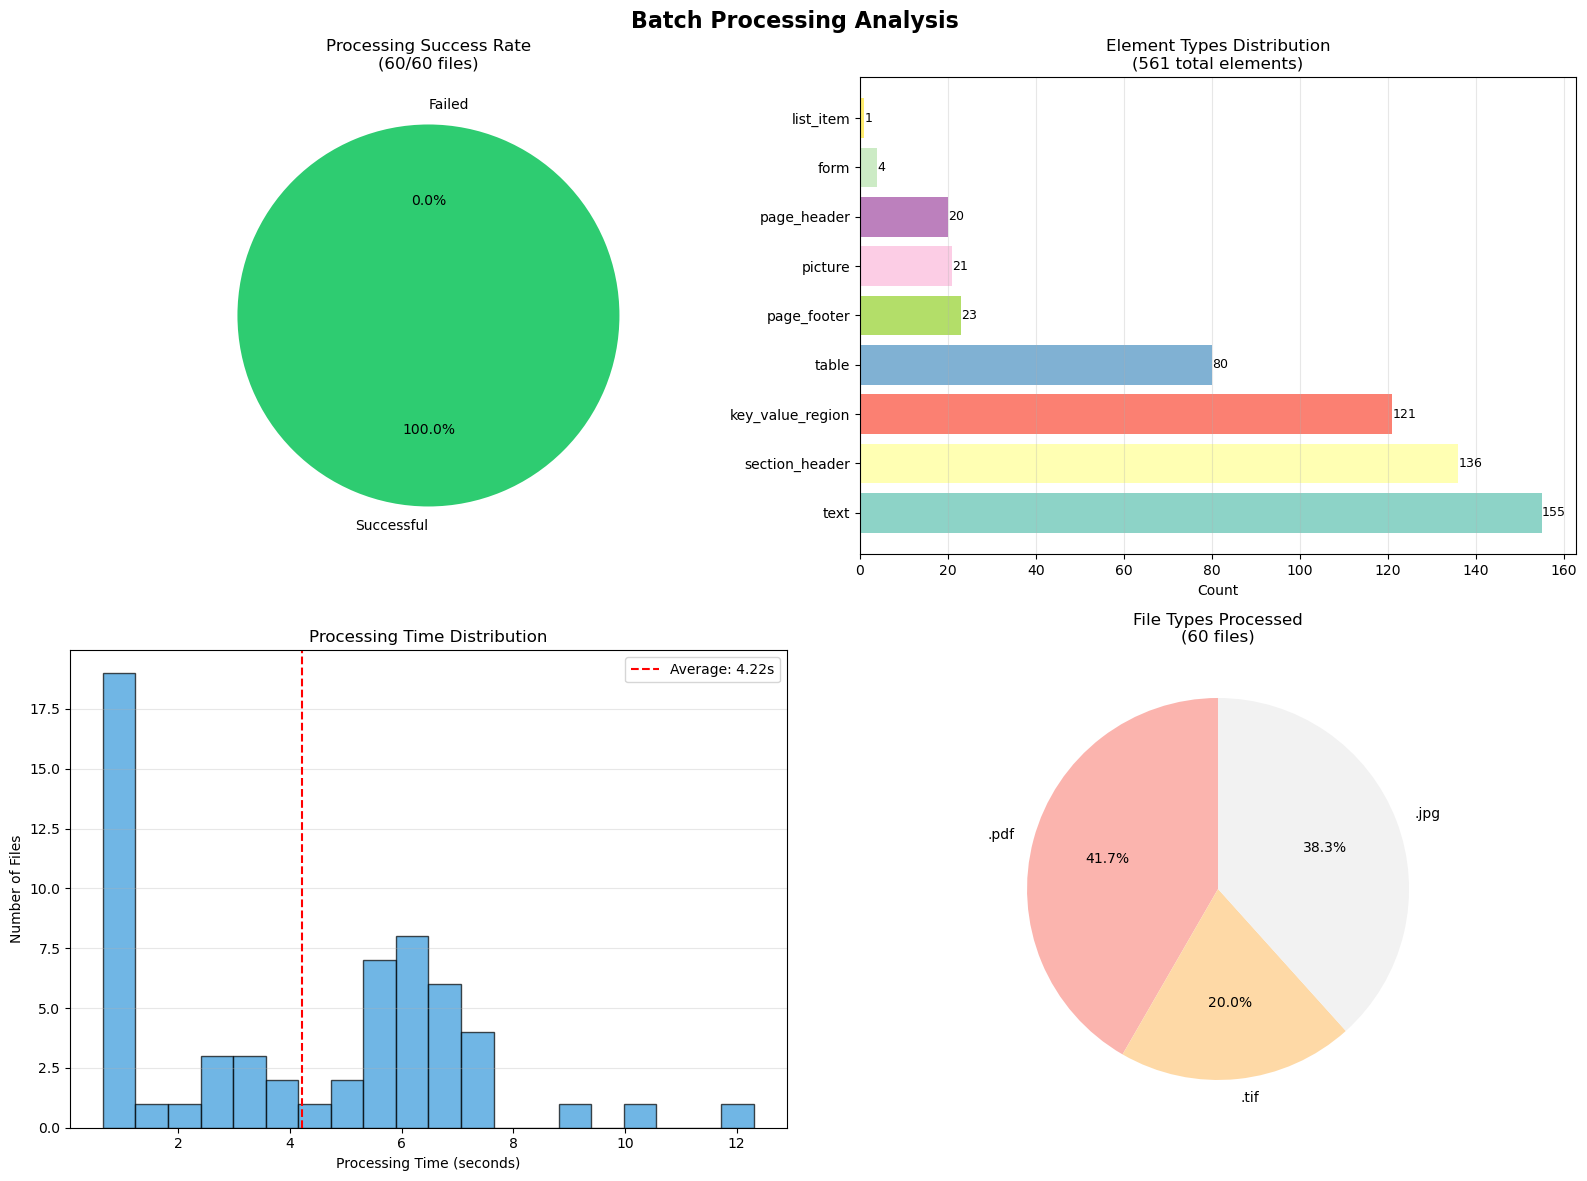


📊 Processing Results Table:
                           File Status Time (s)
invoice_Anna Andreadi_35318.pdf      ✅     1.05
       sliders-454353423425.pdf      ✅     8.90
    shakeshack_20181208_004.pdf      ✅     4.23
invoice_Anna Andreadi_39302.pdf      ✅     1.21
  invoice_Angele Hood_35601.pdf      ✅     1.05
invoice_Anemone Ratner_8876.pdf      ✅     1.03
   spaceneedle_20240528_005.pdf      ✅     1.39
invoice_Anna Andreadi_39300.pdf      ✅     1.16
   invoice_Andy Yotov_37313.pdf      ✅     1.01
invoice_Anna Andreadi_39301.pdf      ✅     0.65
    invoice_Ann Blume_35427.pdf      ✅     1.03
  invoice_Anna Gayman_42837.pdf      ✅     0.98
   invoice_Andy Yotov_37314.pdf      ✅     1.01
          motelone_20240203.pdf      ✅    10.21
invoice_Anna HДberlin_40216.pdf      ✅     0.98
  invoice_Angele Hood_35602.pdf      ✅     1.00
   invoice_Andy Yotov_39986.pdf      ✅     1.01
   invoice_Anna Chung_36194.pdf      ✅     1.01
    happyitaly_20240306_001.pdf      ✅     2.49
invoice_Ann

In [15]:
# Analyze and visualize batch processing results
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image as IPImage, display

if 'batch_results' in locals():
    print("="*70)
    print("BATCH PROCESSING ANALYSIS")
    print("="*70)
    
    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Batch Processing Analysis', fontsize=16, fontweight='bold')
    
    # 1. Success/Failure Pie Chart
    ax1 = axes[0, 0]
    success_data = [batch_results['successful'], batch_results['failed']]
    success_labels = ['Successful', 'Failed']
    colors = ['#2ecc71', '#e74c3c']
    ax1.pie(success_data, labels=success_labels, autopct='%1.1f%%', colors=colors, startangle=90)
    ax1.set_title(f'Processing Success Rate\n({batch_results["successful"]}/{batch_results["total_files"]} files)')
    
    # 2. Element Types Bar Chart
    ax2 = axes[0, 1]
    stats = batch_results['statistics']
    if stats['element_types']:
        elem_types = list(stats['element_types'].keys())
        elem_counts = list(stats['element_types'].values())
        
        # Sort by count
        sorted_data = sorted(zip(elem_types, elem_counts), key=lambda x: x[1], reverse=True)
        elem_types_sorted = [x[0] for x in sorted_data]
        elem_counts_sorted = [x[1] for x in sorted_data]
        
        colors_bar = plt.cm.Set3(np.linspace(0, 1, len(elem_types_sorted)))
        bars = ax2.barh(elem_types_sorted, elem_counts_sorted, color=colors_bar)
        ax2.set_xlabel('Count')
        ax2.set_title(f'Element Types Distribution\n({stats["total_elements"]} total elements)')
        ax2.grid(axis='x', alpha=0.3)
        
        # Add value labels on bars
        for bar in bars:
            width = bar.get_width()
            ax2.text(width, bar.get_y() + bar.get_height()/2, 
                    f'{int(width)}', ha='left', va='center', fontsize=9)
    
    # 3. Processing Time Distribution
    ax3 = axes[1, 0]
    if stats['processing_times']:
        ax3.hist(stats['processing_times'], bins=20, color='#3498db', edgecolor='black', alpha=0.7)
        ax3.axvline(stats['avg_processing_time'], color='red', linestyle='--', 
                   label=f'Average: {stats["avg_processing_time"]:.2f}s')
        ax3.set_xlabel('Processing Time (seconds)')
        ax3.set_ylabel('Number of Files')
        ax3.set_title('Processing Time Distribution')
        ax3.legend()
        ax3.grid(axis='y', alpha=0.3)
    
    # 4. File Types Pie Chart
    ax4 = axes[1, 1]
    if stats['file_types']:
        file_types = list(stats['file_types'].keys())
        file_counts = list(stats['file_types'].values())
        colors_files = plt.cm.Pastel1(np.linspace(0, 1, len(file_types)))
        ax4.pie(file_counts, labels=file_types, autopct='%1.1f%%', colors=colors_files, startangle=90)
        ax4.set_title(f'File Types Processed\n({sum(file_counts)} files)')
    
    plt.tight_layout()
    plt.show()
    
    # Create summary DataFrame
    print("\n📊 Processing Results Table:")
    results_data = []
    for result in batch_results['results']:
        results_data.append({
            'File': result['file'],
            'Status': '✅' if result['success'] else '❌',
            'Time (s)': f"{result['processing_time']:.2f}"
        })
    
    df_results = pd.DataFrame(results_data)
    print(df_results.to_string(index=False))
    
    # Save summary report
    report_path = output_base_dir / "batch_processing_report.txt"
    with open(report_path, 'w', encoding='utf-8') as f:
        f.write("="*70 + "\n")
        f.write("BATCH PROCESSING SUMMARY REPORT\n")
        f.write("="*70 + "\n")
        f.write(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
        
        f.write(f"OVERVIEW:\n")
        f.write(f"  Total files processed: {batch_results['total_files']}\n")
        f.write(f"  Successful: {batch_results['successful']}\n")
        f.write(f"  Failed: {batch_results['failed']}\n")
        f.write(f"  Success rate: {(batch_results['successful']/batch_results['total_files']*100):.1f}%\n")
        f.write(f"  Total processing time: {batch_results['total_processing_time']:.2f}s\n\n")
        
        f.write(f"CONTENT STATISTICS:\n")
        f.write(f"  Total pages: {stats['total_pages']}\n")
        f.write(f"  Total elements: {stats['total_elements']}\n")
        if BATCH_CONFIG['enable_cropping']:
            f.write(f"  Total crops: {stats['total_crops']}\n")
        f.write(f"\n")
        
        f.write(f"PROCESSING TIMES:\n")
        if stats['processing_times']:
            f.write(f"  Average: {stats['avg_processing_time']:.2f}s\n")
            f.write(f"  Minimum: {stats['min_processing_time']:.2f}s\n")
            f.write(f"  Maximum: {stats['max_processing_time']:.2f}s\n")
        f.write(f"\n")
        
        f.write(f"FILE TYPES:\n")
        for file_type, count in sorted(stats['file_types'].items()):
            f.write(f"  {file_type}: {count}\n")
        f.write(f"\n")
        
        f.write(f"ELEMENT TYPES:\n")
        for elem_type, count in sorted(stats['element_types'].items(), key=lambda x: x[1], reverse=True):
            f.write(f"  {elem_type}: {count}\n")
        f.write(f"\n")
        
        f.write(f"DETAILED RESULTS:\n")
        f.write(df_results.to_string(index=False))
        f.write(f"\n\n")
        
        if batch_results['errors']:
            f.write(f"ERRORS:\n")
            for error in batch_results['errors']:
                f.write(f"  • {Path(error['file']).name}: {error['error']}\n")
    
    print(f"\n✓ Summary report saved to: {report_path}")
    
else:
    print("No batch results available. Run cell 12 first to process files.")


## 14. Summary and Next Steps

In [16]:
print("\n" + "="*60)
print("NOTEBOOK SUMMARY")
print("="*60)
print("\n✓ Features Implemented:")
print("  • Multi-format support (PDF, TIFF, JPG, PNG)")
print("  • Layout detection with Docling")
print("  • Reading order extraction and maintenance")
print("  • Spatial reading order computation (fallback)")
print("  • Visualization with reading order numbers")
print("  • Section cropping by reading order")
print("  • Crops overview generation")
print("  • Comprehensive JSON output")
print("  • Batch processing capability")

print("\n✓ Output Structure:")
print("  output_results/")
print("    └── [filename]/")
print("        ├── converted_images/")
print("        │   └── page_XXX.png")
print("        ├── visualizations/")
print("        │   └── page_XXX_reading_order.png")
print("        ├── cropped_sections/")
print("        │   ├── page_XXX_order_XXX_[type]_id_[id].png")
print("        │   ├── crops_overview.png")
print("        │   └── cropping_metadata.json")
print("        └── layout_data.json (with reading_order field)")

print("\n📊 Reading Order Information:")
print("  • Each element has a 'reading_order' field (1-based)")
print("  • Elements are sorted by reading order in output")
print("  • Visualizations show red badges with reading order numbers")
print("  • 'reading_order_available' flag indicates if RO was detected")
print("  • 'reading_order_method' shows if it's 'model' or 'spatial'")

print("\n✂️  Section Cropping:")
print("  • Each section is cropped as a separate image")
print("  • Filename includes: page, reading order, element type, ID")
print("  • Configurable padding around each crop")
print("  • Overview image shows all crops in grid layout")
print("  • Metadata JSON contains all crop information")

print("\n🎯 Next Steps:")
print("  1. Process more files from test_data")
print("  2. Analyze reading order patterns")
print("  3. Use cropped sections for downstream tasks")
print("  4. Fine-tune model parameters if needed")
print("  5. Export crops for OCR, classification, etc.")



NOTEBOOK SUMMARY

✓ Features Implemented:
  • Multi-format support (PDF, TIFF, JPG, PNG)
  • Layout detection with Docling
  • Reading order extraction and maintenance
  • Spatial reading order computation (fallback)
  • Visualization with reading order numbers
  • Section cropping by reading order
  • Crops overview generation
  • Comprehensive JSON output
  • Batch processing capability

✓ Output Structure:
  output_results/
    └── [filename]/
        ├── converted_images/
        │   └── page_XXX.png
        ├── visualizations/
        │   └── page_XXX_reading_order.png
        ├── cropped_sections/
        │   ├── page_XXX_order_XXX_[type]_id_[id].png
        │   ├── crops_overview.png
        │   └── cropping_metadata.json
        └── layout_data.json (with reading_order field)

📊 Reading Order Information:
  • Each element has a 'reading_order' field (1-based)
  • Elements are sorted by reading order in output
  • Visualizations show red badges with reading order numbers
  • 'r

In [17]:
## 15. Crop Sections by Reading Order

In [18]:
def crop_sections_by_reading_order(layout_data: Dict[str, Any], image_paths: List[str], 
                                   output_dir: Path, padding: int = 10) -> Dict[str, Any]:
    """
    Crop each section based on reading order and save as separate images.
    
    Args:
        layout_data: Layout information with reading order
        image_paths: List of paths to page images
        output_dir: Output directory for cropped sections
        padding: Padding around each crop (in pixels)
    
    Returns:
        Dictionary with cropping results
    """
    crops_dir = output_dir / "cropped_sections"
    crops_dir.mkdir(parents=True, exist_ok=True)
    
    cropping_results = {
        "total_crops": 0,
        "pages": []
    }
    
    for page_data in layout_data.get('pages', []):
        page_num = page_data['page_number']
        page_result = {
            "page_number": page_num,
            "crops": [],
            "success": True
        }
        
        # Get corresponding image
        if page_num - 1 < len(image_paths):
            image_path = image_paths[page_num - 1]
            
            try:
                # Open image
                img = Image.open(image_path)
                img_width, img_height = img.size
                
                # Get page dimensions for scaling
                page_width = page_data['dimensions']['width']
                page_height = page_data['dimensions']['height']
                
                if page_width and page_height:
                    scale_x = img_width / page_width
                    scale_y = img_height / page_height
                else:
                    scale_x, scale_y = 1.0, 1.0
                
                # Sort elements by reading order
                elements = sorted(
                    page_data['elements'],
                    key=lambda x: x.get('reading_order', 999999)
                )
                
                logger.info(f"Cropping {len(elements)} sections from page {page_num}")
                
                # Crop each element
                for elem in elements:
                    ro = elem.get('reading_order', 0)
                    elem_type = elem['type']
                    bbox = elem['bounding_box']
                    
                    # Calculate crop coordinates with scaling and padding
                    left = max(0, int(bbox['left'] * scale_x) - padding)
                    top = max(0, int(bbox['top'] * scale_y) - padding)
                    right = min(img_width, int(bbox['right'] * scale_x) + padding)
                    bottom = min(img_height, int(bbox['bottom'] * scale_y) + padding)
                    
                    # Crop image
                    cropped = img.crop((left, top, right, bottom))
                    
                    # Generate filename
                    elem_id = elem.get('id', 'unknown')
                    safe_type = elem_type.replace(' ', '_').replace('/', '_')
                    crop_filename = f"page_{page_num:03d}_order_{ro:03d}_{safe_type}_id_{elem_id}.png"
                    crop_path = crops_dir / crop_filename
                    
                    # Save cropped image
                    cropped.save(crop_path)
                    
                    crop_info = {
                        "reading_order": ro,
                        "element_id": elem_id,
                        "element_type": elem_type,
                        "crop_path": str(crop_path),
                        "crop_filename": crop_filename,
                        "original_bbox": bbox,
                        "crop_size": {
                            "width": cropped.width,
                            "height": cropped.height
                        },
                        "confidence": elem.get('confidence')
                    }
                    
                    page_result["crops"].append(crop_info)
                    cropping_results["total_crops"] += 1
                
                logger.info(f"✓ Cropped {len(page_result['crops'])} sections from page {page_num}")
                
            except Exception as e:
                logger.error(f"Error cropping sections from page {page_num}: {e}")
                page_result["success"] = False
                page_result["error"] = str(e)
        else:
            logger.warning(f"No image found for page {page_num}")
            page_result["success"] = False
            page_result["error"] = "Image not found"
        
        cropping_results["pages"].append(page_result)
    
    # Save cropping metadata
    metadata_path = crops_dir / "cropping_metadata.json"
    with open(metadata_path, 'w', encoding='utf-8') as f:
        json.dump(cropping_results, f, indent=2, ensure_ascii=False)
    
    logger.info(f"✓ Total crops saved: {cropping_results['total_crops']}")
    logger.info(f"✓ Cropping metadata saved to: {metadata_path}")
    
    return cropping_results


def create_crops_overview(crops_dir: Path, cropping_results: Dict[str, Any]) -> Optional[str]:
    """
    Create a visual overview showing all cropped sections in reading order.
    
    Args:
        crops_dir: Directory containing cropped images
        cropping_results: Results from crop_sections_by_reading_order
    
    Returns:
        Path to overview image
    """
    try:
        # Collect all crop images
        all_crops = []
        for page_result in cropping_results['pages']:
            for crop_info in page_result.get('crops', []):
                crop_path = Path(crop_info['crop_path'])
                if crop_path.exists():
                    all_crops.append({
                        'path': crop_path,
                        'order': crop_info['reading_order'],
                        'type': crop_info['element_type'],
                        'page': page_result['page_number']
                    })
        
        if not all_crops:
            logger.warning("No crops found to create overview")
            return None
        
        # Load all crop images
        images = []
        for crop_data in all_crops:
            img = Image.open(crop_data['path'])
            images.append({
                'image': img,
                'order': crop_data['order'],
                'type': crop_data['type'],
                'page': crop_data['page']
            })
        
        # Calculate overview dimensions (3 columns)
        cols = 3
        rows = (len(images) + cols - 1) // cols
        
        # Find max dimensions for uniform sizing
        max_width = max(img['image'].width for img in images)
        max_height = max(img['image'].height for img in images)
        
        # Add margins
        margin = 20
        label_height = 30
        cell_width = max_width + margin * 2
        cell_height = max_height + margin * 2 + label_height
        
        # Create overview canvas
        overview_width = cell_width * cols
        overview_height = cell_height * rows + 100  # Extra space for title
        overview = Image.new('RGB', (overview_width, overview_height), color='white')
        draw = ImageDraw.Draw(overview)
        
        # Load font
        try:
            font = ImageFont.truetype("arial.ttf", 14)
            title_font = ImageFont.truetype("arial.ttf", 24)
        except:
            font = ImageFont.load_default()
            title_font = ImageFont.load_default()
        
        # Draw title
        title = f"Cropped Sections by Reading Order ({len(images)} sections)"
        draw.rectangle([(0, 0), (overview_width, 80)], fill='#2c3e50')
        draw.text((20, 25), title, fill='white', font=title_font)
        
        # Place images in grid
        for idx, img_data in enumerate(images):
            row = idx // cols
            col = idx % cols
            
            x = col * cell_width + margin
            y = row * cell_height + 100 + margin  # 100 for title space
            
            # Paste image
            overview.paste(img_data['image'], (x, y))
            
            # Draw border
            draw.rectangle(
                [(x - 2, y - 2), 
                 (x + img_data['image'].width + 2, y + img_data['image'].height + 2)],
                outline='#3498db',
                width=2
            )
            
            # Draw label
            label_y = y + img_data['image'].height + 5
            label_text = f"[{img_data['order']}] {img_data['type']}"
            
            # Background for label
            text_bbox = draw.textbbox((x, label_y), label_text, font=font)
            draw.rectangle(
                [(text_bbox[0] - 3, text_bbox[1] - 2),
                 (text_bbox[2] + 3, text_bbox[3] + 2)],
                fill='white',
                outline='#3498db',
                width=1
            )
            
            draw.text((x, label_y), label_text, fill='#2c3e50', font=font)
        
        # Save overview
        overview_path = crops_dir / "crops_overview.png"
        overview.save(overview_path)
        logger.info(f"✓ Crops overview saved to: {overview_path}")
        
        return str(overview_path)
        
    except Exception as e:
        logger.error(f"Error creating crops overview: {e}")
        return None


print("✓ Section cropping functions defined")

✓ Section cropping functions defined


## 16. Crop Sections from Processed Documents

In [19]:
# Crop sections from the last processed document
if 'results' in locals() and results['success']:
    print("Cropping sections from processed document...")
    print("="*60)
    
    # Get layout data and image paths
    layout_data = results['steps']['layout_detection']
    image_paths = []
    
    # Find converted images
    converted_images_dir = Path(results['output_directory']) / "converted_images"
    if converted_images_dir.exists():
        image_paths = sorted(list(converted_images_dir.glob("page_*.png")))
        image_paths = [str(p) for p in image_paths]
    
    if image_paths:
        # Crop sections
        output_dir = Path(results['output_directory'])
        cropping_results = crop_sections_by_reading_order(
            layout_data, 
            image_paths, 
            output_dir, 
            padding=15  # Add 15 pixels padding around each crop
        )
        
        # Display summary
        print(f"\n✓ Cropping completed!")
        print(f"  Total sections cropped: {cropping_results['total_crops']}")
        print(f"  Output directory: {output_dir / 'cropped_sections'}")
        
        # Show details per page
        print("\nCrops per page:")
        for page_result in cropping_results['pages']:
            page_num = page_result['page_number']
            num_crops = len(page_result.get('crops', []))
            status = "✓" if page_result['success'] else "✗"
            print(f"  Page {page_num}: {status} {num_crops} sections cropped")
        
        # Create overview visualization
        print("\nCreating overview visualization...")
        crops_dir = output_dir / "cropped_sections"
        overview_path = create_crops_overview(crops_dir, cropping_results)
        
        if overview_path:
            print(f"✓ Overview created: {overview_path}")
        
        # Show some examples
        print("\nFirst 5 cropped sections (by reading order):")
        all_crops = []
        for page_result in cropping_results['pages']:
            all_crops.extend(page_result.get('crops', []))
        
        all_crops.sort(key=lambda x: (x.get('reading_order', 999)))
        
        for i, crop in enumerate(all_crops[:5], 1):
            print(f"  {i}. [Order {crop['reading_order']}] {crop['element_type']}")
            print(f"     File: {crop['crop_filename']}")
            print(f"     Size: {crop['crop_size']['width']}x{crop['crop_size']['height']} px")
    else:
        print("No converted images found. Process a document first.")
else:
    print("No processed document available. Run cell 11 first to process a document.")

2025-10-23 18:33:44,121 - INFO - Cropping 6 sections from page 1
2025-10-23 18:33:44,274 - INFO - ✓ Cropped 6 sections from page 1
2025-10-23 18:33:44,275 - INFO - ✓ Total crops saved: 6
2025-10-23 18:33:44,276 - INFO - ✓ Cropping metadata saved to: output_results/invoice_Anna Andreadi_35318/cropped_sections/cropping_metadata.json


Cropping sections from processed document...

✓ Cropping completed!
  Total sections cropped: 6
  Output directory: output_results/invoice_Anna Andreadi_35318/cropped_sections

Crops per page:
  Page 1: ✓ 6 sections cropped

Creating overview visualization...


2025-10-23 18:33:44,630 - INFO - ✓ Crops overview saved to: output_results/invoice_Anna Andreadi_35318/cropped_sections/crops_overview.png


✓ Overview created: output_results/invoice_Anna Andreadi_35318/cropped_sections/crops_overview.png

First 5 cropped sections (by reading order):
  1. [Order 1] page_header
     File: page_001_order_001_page_header_id_3.png
     Size: 248x70 px
  2. [Order 2] section_header
     File: page_001_order_002_section_header_id_15.png
     Size: 505x146 px
  3. [Order 3] text
     File: page_001_order_003_text_id_14.png
     Size: 210x80 px
  4. [Order 4] key_value_region
     File: page_001_order_004_key_value_region_id_19.png
     Size: 2195x292 px
  5. [Order 5] table
     File: page_001_order_005_table_id_5.png
     Size: 2336x815 px


## 17. Display Cropped Sections

CROPPED SECTIONS OVERVIEW


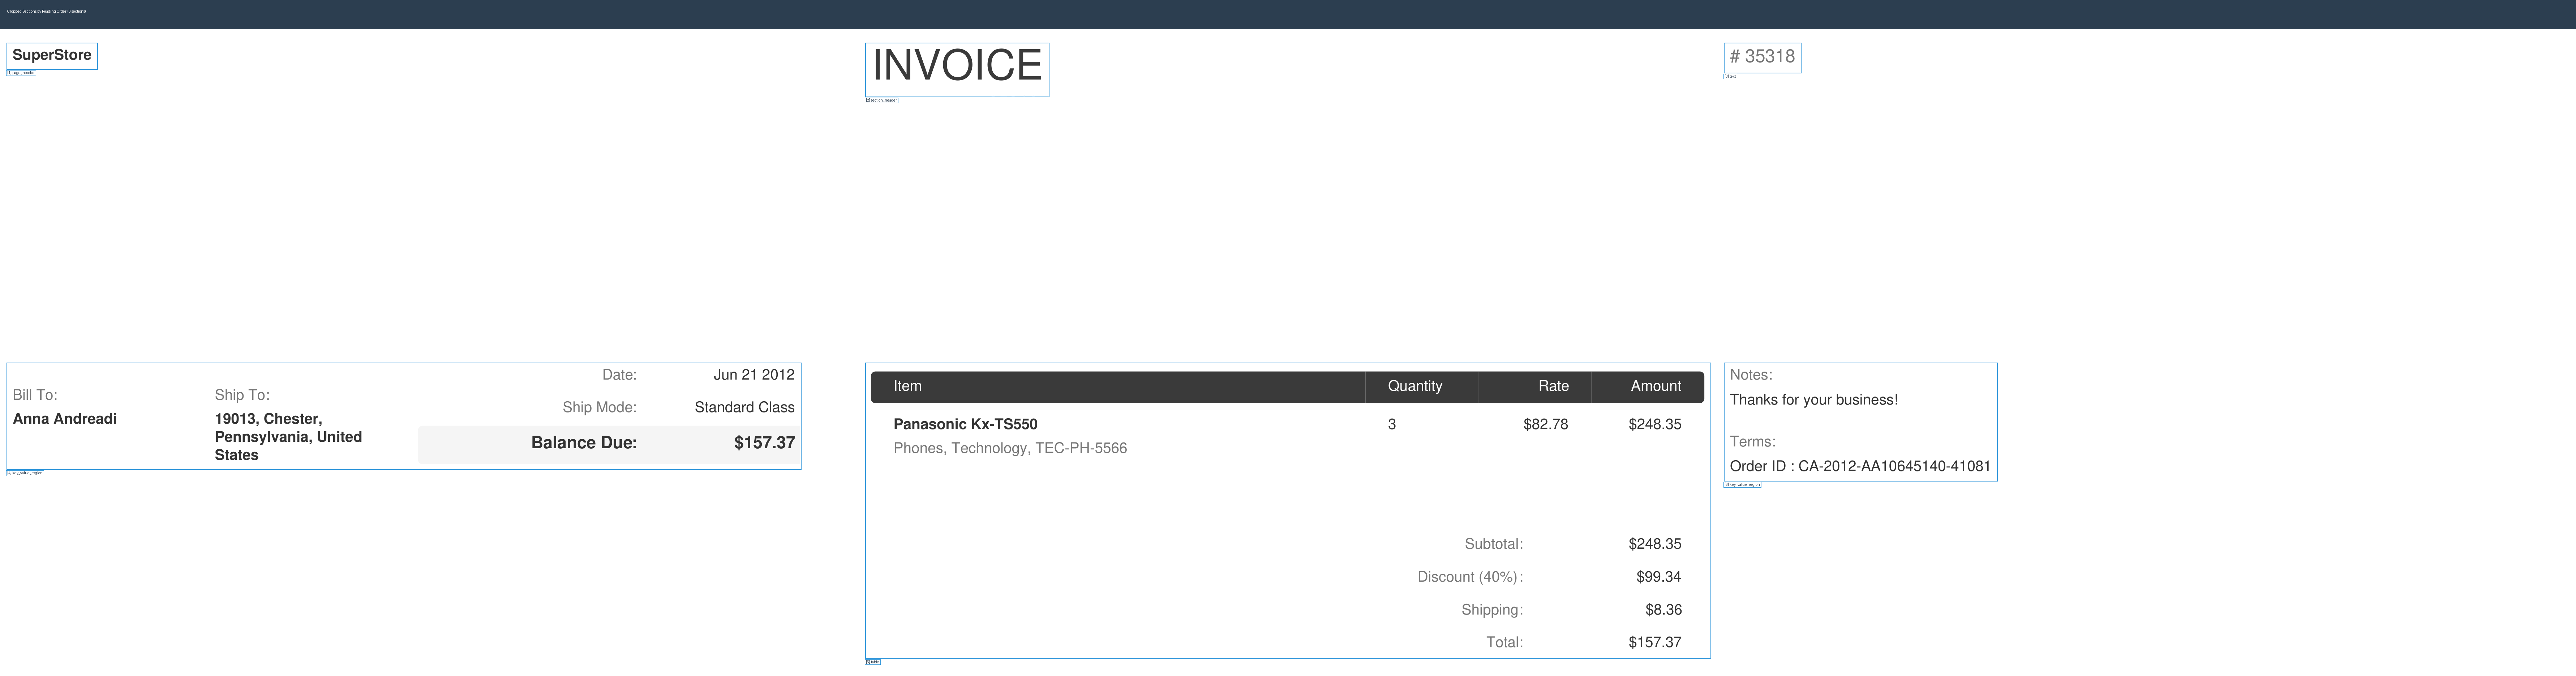


6 cropped sections found

Displaying first 6 sections in reading order:


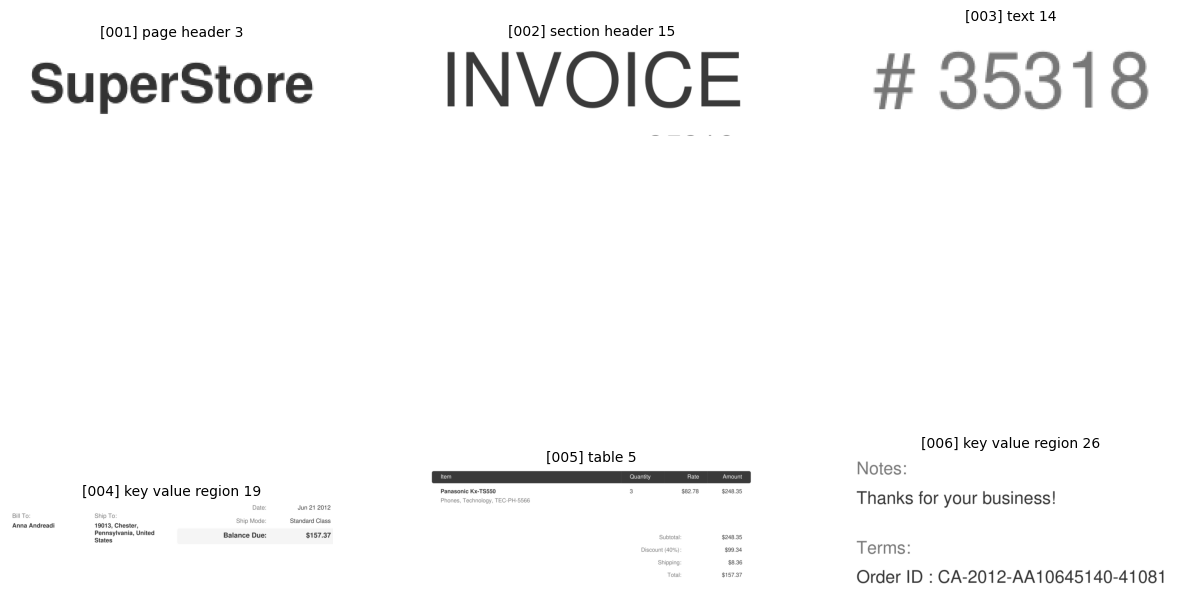


✓ Individual crops displayed


In [20]:
# Display the overview and some individual crops
from IPython.display import Image as IPImage, display
import matplotlib.pyplot as plt
from matplotlib import gridspec

# Display overview
overview_files = list(output_base_dir.glob("**/cropped_sections/crops_overview.png"))
if overview_files:
    print("=" * 60)
    print("CROPPED SECTIONS OVERVIEW")
    print("=" * 60)
    display(IPImage(filename=str(overview_files[0])))
else:
    print("No overview found. Run cell 16 first to crop sections.")

# Display individual crops in reading order
crops_dirs = list(output_base_dir.glob("**/cropped_sections"))
if crops_dirs and crops_dirs[0].exists():
    crop_files = sorted(crops_dirs[0].glob("page_*_order_*.png"))
    
    if crop_files:
        print(f"\n{len(crop_files)} cropped sections found")
        print("\nDisplaying first 6 sections in reading order:")
        
        # Create figure with subplots
        fig = plt.figure(figsize=(15, 10))
        gs = gridspec.GridSpec(2, 3, figure=fig, hspace=0.3, wspace=0.3)
        
        for idx, crop_file in enumerate(crop_files[:6]):
            ax = fig.add_subplot(gs[idx // 3, idx % 3])
            
            # Load and display image
            img = plt.imread(crop_file)
            ax.imshow(img)
            ax.axis('off')
            
            # Parse filename for info
            filename = crop_file.stem
            parts = filename.split('_')
            try:
                order_idx = parts.index('order')
                order_num = parts[order_idx + 1]
                type_start = order_idx + 2
                elem_type = ' '.join(parts[type_start:]).replace(' id', '').strip()
                
                ax.set_title(f"[{order_num}] {elem_type}", fontsize=10, pad=5)
            except:
                ax.set_title(filename, fontsize=8, pad=5)
        
        plt.tight_layout()
        plt.show()
        
        print("\n✓ Individual crops displayed")
    else:
        print("No crop files found")
else:
    print("No crops directory found")

## 18. Enhanced Processing with Auto-Cropping

In [24]:
def process_document_with_cropping(input_path: Path, output_dir: Path, converter, 
                                   config: Dict, crop_padding: int = 15) -> Dict[str, Any]:
    """
    Enhanced processing function that includes automatic section cropping.
    
    Args:
        input_path: Path to input document
        output_dir: Output directory
        converter: Document converter instance
        config: Configuration dictionary
        crop_padding: Padding around crops in pixels
    
    Returns:
        Complete processing results including cropping info
    """
    # Run standard processing
    results = process_document(input_path, output_dir, converter, config)
    
    # Add cropping step if processing was successful
    if results['success'] and 'layout_detection' in results['steps']:
        try:
            logger.info("Step 4: Cropping sections by reading order...")
            
            # Get image paths
            image_paths = []
            converted_images_dir = output_dir / "converted_images"
            if converted_images_dir.exists():
                image_paths = sorted(list(converted_images_dir.glob("page_*.png")))
                image_paths = [str(p) for p in image_paths]
            
            if image_paths:
                # Crop sections
                layout_data = results['steps']['layout_detection']
                cropping_results = crop_sections_by_reading_order(
                    layout_data, 
                    image_paths, 
                    output_dir, 
                    padding=crop_padding
                )
                
                # Add to results
                results['steps']['cropping'] = cropping_results
                
                # Create overview
                crops_dir = output_dir / "cropped_sections"
                overview_path = create_crops_overview(crops_dir, cropping_results)
                
                if overview_path:
                    results['steps']['cropping']['overview_path'] = overview_path
                
                logger.info(f"✓ Cropped {cropping_results['total_crops']} sections")
            else:
                logger.warning("No images found for cropping")
                results['steps']['cropping'] = {"error": "No images found"}
                
        except Exception as e:
            logger.error(f"Error during cropping: {e}")
            results['steps']['cropping'] = {"error": str(e)}
    
    return results


print("✓ Enhanced processing function with auto-cropping defined")

✓ Enhanced processing function with auto-cropping defined


## 19. Test Enhanced Processing with Cropping

In [25]:
# Test enhanced processing with automatic cropping
if supported_files and len(supported_files) > 1:
    # Process a different file to demonstrate
    test_file = supported_files[1] if len(supported_files) > 1 else supported_files[0]
    test_output_dir = output_base_dir / (test_file.stem + "_with_crops")
    
    print("=" * 60)
    print("ENHANCED PROCESSING WITH AUTO-CROPPING")
    print("=" * 60)
    print(f"Processing: {test_file.name}\n")
    
    # Process with cropping
    enhanced_results = process_document_with_cropping(
        test_file, 
        test_output_dir, 
        converter, 
        CONFIG,
        crop_padding=20  # 20 pixels padding
    )
    
    # Display results
    print("\n" + "=" * 60)
    print("ENHANCED PROCESSING RESULTS")
    print("=" * 60)
    print(f"File: {enhanced_results['input_file']}")
    print(f"Success: {enhanced_results['success']}")
    print(f"Time: {enhanced_results['processing_time']:.2f} seconds")
    
    if enhanced_results['success']:
        steps = enhanced_results['steps']
        
        # Layout detection info
        if 'layout_detection' in steps:
            layout = steps['layout_detection']
            metadata = layout['document_metadata']
            print(f"\n📄 Layout Detection:")
            print(f"  Pages: {metadata['total_pages']}")
            print(f"  Elements: {metadata['element_statistics']['total_elements']}")
            
            pages_with_ro = sum(1 for p in layout['pages'] if p.get('reading_order_available', False))
            print(f"  Reading order: {pages_with_ro}/{metadata['total_pages']} pages")
        
        # Cropping info
        if 'cropping' in steps and 'error' not in steps['cropping']:
            cropping = steps['cropping']
            print(f"\n✂️  Section Cropping:")
            print(f"  Total sections cropped: {cropping['total_crops']}")
            print(f"  Output directory: {test_output_dir / 'cropped_sections'}")
            
            if 'overview_path' in cropping:
                print(f"  Overview image: {Path(cropping['overview_path']).name}")
            
            # Show crop details
            print(f"\n  Crops by page:")
            for page_result in cropping['pages']:
                num_crops = len(page_result.get('crops', []))
                status = "✓" if page_result['success'] else "✗"
                print(f"    Page {page_result['page_number']}: {status} {num_crops} sections")
            
            # List some crop files
            print(f"\n  Sample cropped files:")
            all_crops = []
            for page_result in cropping['pages']:
                all_crops.extend(page_result.get('crops', []))
            
            for i, crop in enumerate(sorted(all_crops, key=lambda x: x['reading_order'])[:3], 1):
                print(f"    {i}. [Order {crop['reading_order']}] {crop['crop_filename']}")
        
        print(f"\n✓ Complete! Check output at: {test_output_dir}")
        
else:
    print("Need at least one file in test_data to process")
    print("Run cell 10 first to scan for files")

2025-10-23 18:42:02,576 - INFO - 
2025-10-23 18:42:02,577 - INFO - Processing: sliders-454353423425.pdf
2025-10-23 18:42:02,577 - INFO - ============================================================
2025-10-23 18:42:02,577 - INFO - Step 1: Converting to images...
2025-10-23 18:42:02,578 - INFO - Converting PDF to images (DPI: 300)...


ENHANCED PROCESSING WITH AUTO-CROPPING
Processing: sliders-454353423425.pdf



2025-10-23 18:42:03,432 - INFO - ✓ Converted 1 pages
2025-10-23 18:42:03,432 - INFO - Step 2: Performing layout detection with reading order...
2025-10-23 18:42:03,434 - INFO - detected formats: [<InputFormat.PDF: 'pdf'>]
2025-10-23 18:42:03,435 - INFO - Going to convert document batch...
2025-10-23 18:42:03,436 - INFO - Processing document sliders-454353423425.pdf
2025-10-23 18:42:05,440 - INFO - Finished converting document sliders-454353423425.pdf in 2.01 sec.
2025-10-23 18:42:05,441 - INFO - Page 1: Model reading order not available, computing spatial reading order...
2025-10-23 18:42:05,441 - INFO - Step 3: Generating visualizations with reading order...
2025-10-23 18:42:07,695 - INFO - ✓ Created reading order visualization: output_results/sliders-454353423425_with_crops/visualizations/page_001_reading_order.png
2025-10-23 18:42:07,696 - INFO - ✓ Saved layout data to output_results/sliders-454353423425_with_crops/layout_data.json
2025-10-23 18:42:07,697 - INFO - 
✓ Processing comp


ENHANCED PROCESSING RESULTS
File: test_data/sliders-454353423425.pdf
Success: True
Time: 5.12 seconds

📄 Layout Detection:
  Pages: 1
  Elements: 2
  Reading order: 1/1 pages

✂️  Section Cropping:
  Total sections cropped: 2
  Output directory: output_results/sliders-454353423425_with_crops/cropped_sections
  Overview image: crops_overview.png

  Crops by page:
    Page 1: ✓ 2 sections

  Sample cropped files:
    1. [Order 1] page_001_order_001_picture_id_6.png
    2. [Order 2] page_001_order_002_key_value_region_id_22.png

✓ Complete! Check output at: output_results/sliders-454353423425_with_crops


## 20. Summary

### 🎉 Complete PDF/Image Layout Detection Pipeline

This notebook provides a **comprehensive solution** for document layout analysis with the following features:

#### **Core Capabilities:**
1. **Multi-Format Support**: PDF, TIFF (multi-page), JPG, JPEG, PNG
2. **Layout Detection**: Using Docling's state-of-the-art models
3. **Reading Order**: Both model-based and spatial fallback computation
4. **Section Cropping**: Automatic extraction of each section by reading order
5. **Rich Visualizations**: Bounding boxes, confidence scores, reading order badges
6. **Batch Processing**: Process multiple documents efficiently

#### **Output Files:**

**For each processed document, you get:**
- ✅ `converted_images/` - High-quality page images
- ✅ `visualizations/` - Annotated images with reading order
- ✅ `cropped_sections/` - Individual section images (by reading order)
  - Format: `page_001_order_001_section_header_id_19.png`
  - Includes overview grid showing all sections
  - Metadata JSON with crop details
- ✅ `layout_data.json` - Complete structural data

#### **Reading Order:**
- **Method 1 (Model)**: Uses Docling's AI-based reading order detection
- **Method 2 (Spatial)**: Fallback algorithm using top-to-bottom, left-to-right logic
- Always guaranteed to have reading order for every element!

#### **Use Cases:**
- 📄 Document digitization and archiving
- 🔍 Document structure analysis
- 📊 Table and form extraction
- 🤖 Training data preparation for ML models
- 📝 Content extraction pipelines
- 🎯 Section-specific OCR or analysis

#### **Quick Start:**
1. Run cells 1-9 to set up environment
2. Run cell 10 to scan your documents
3. Run cell 11 or 19 to process documents (with/without auto-cropping)
4. Check the `output_results/` directory for all outputs!

---

**Created with**: Docling, PyMuPDF, PIL, and lots of ❤️

## 21. View Sample Outputs from Batch Processing

SAMPLE OUTPUTS FROM BATCH PROCESSING

Found 61 processed documents

📁 Output directories:
  1. 0001139626
     📄 JSON | 🎨 Viz
  2. 0001139716
     📄 JSON | 🎨 Viz
  3. 0013046347
     📄 JSON | 🎨 Viz
  4. 00920576
     📄 JSON | 🎨 Viz
  5. 00921466
     📄 JSON | 🎨 Viz
  6. 00922240
     📄 JSON | 🎨 Viz
  7. 2085538660
     📄 JSON | 🎨 Viz
  8. 50120516-0516
     📄 JSON | 🎨 Viz
  9. batch1-0001
     📄 JSON | 🎨 Viz
  10. batch1-0003
     📄 JSON | 🎨 Viz
  ... and 51 more

SAMPLE VISUALIZATIONS (First 3 Documents)

📄 Document 1: 0001139626
----------------------------------------------------------------------
  Reading Order Visualization:


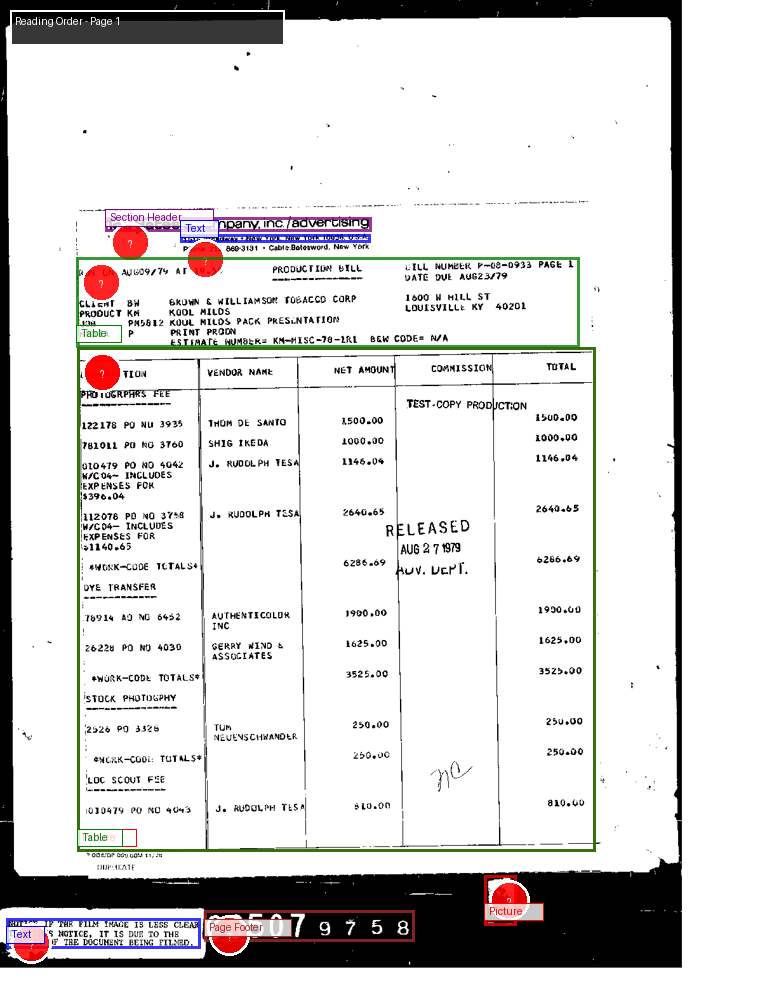


----------------------------------------------------------------------

📄 Document 2: 0001139716
----------------------------------------------------------------------
  Reading Order Visualization:


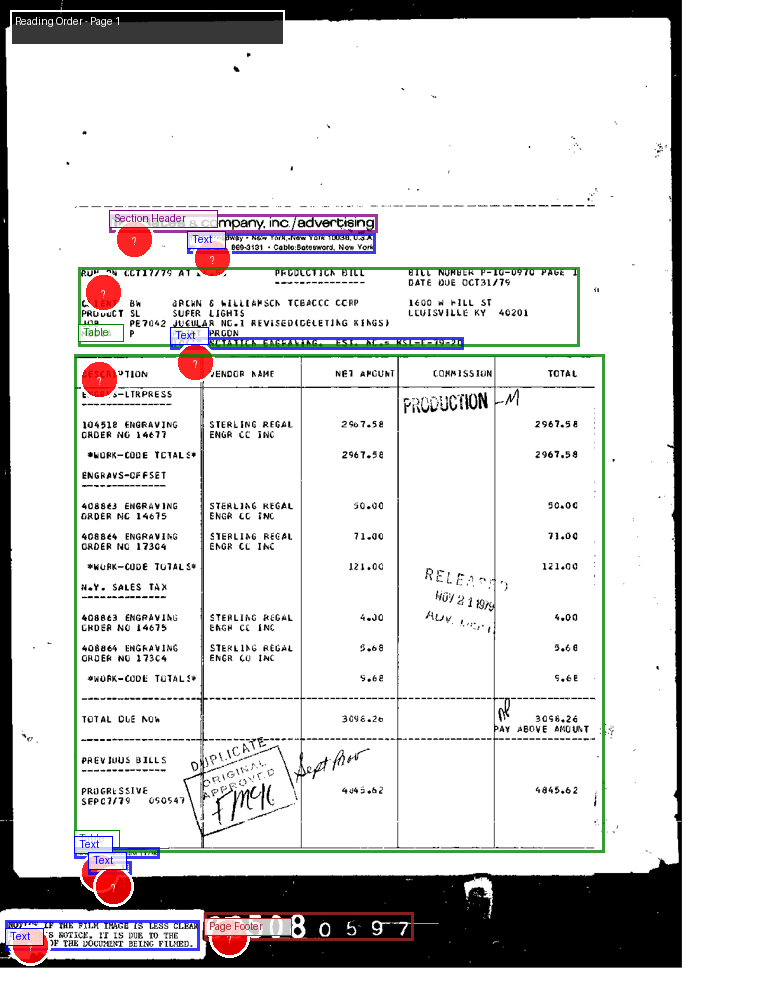


----------------------------------------------------------------------

📄 Document 3: 0013046347
----------------------------------------------------------------------
  Reading Order Visualization:


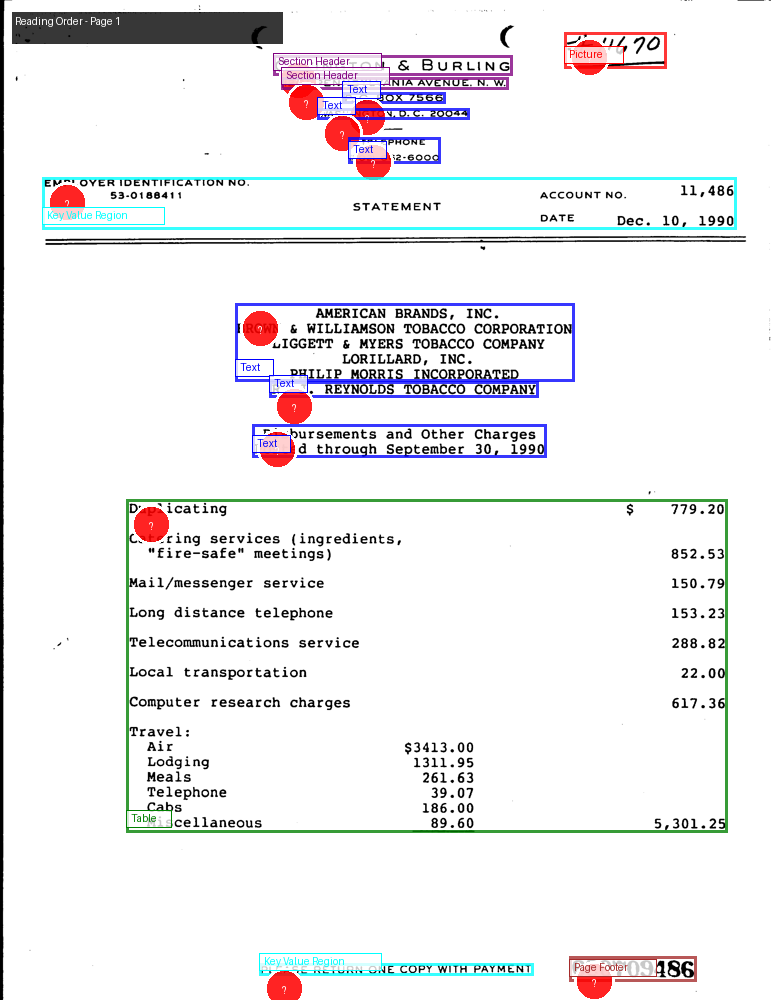


----------------------------------------------------------------------

OUTPUT STATISTICS
  Total visualizations: 63
  Total cropped sections: 8
  Total JSON files: 61
  Average crops per document: 0.1
  Total disk space: 79.70 MB

✓ All outputs saved in: output_results


In [26]:
# Display sample outputs from batch processing
from IPython.display import Image as IPImage, display

print("="*70)
print("SAMPLE OUTPUTS FROM BATCH PROCESSING")
print("="*70)

# Find all processing outputs
output_dirs = sorted([d for d in output_base_dir.iterdir() if d.is_dir()])

if output_dirs:
    print(f"\nFound {len(output_dirs)} processed documents\n")
    
    # Show overview of outputs
    print("📁 Output directories:")
    for i, output_dir in enumerate(output_dirs[:10], 1):  # Show first 10
        print(f"  {i}. {output_dir.name}")
        
        # Check what files exist
        has_layout = (output_dir / "layout_data.json").exists()
        has_viz = len(list(output_dir.glob("visualizations/*.png"))) > 0
        has_crops = (output_dir / "cropped_sections").exists() and \
                    len(list((output_dir / "cropped_sections").glob("*.png"))) > 0
        
        indicators = []
        if has_layout: indicators.append("📄 JSON")
        if has_viz: indicators.append("🎨 Viz")
        if has_crops: indicators.append("✂️ Crops")
        
        if indicators:
            print(f"     {' | '.join(indicators)}")
    
    if len(output_dirs) > 10:
        print(f"  ... and {len(output_dirs) - 10} more")
    
    # Display sample visualizations from first few documents
    print("\n" + "="*70)
    print("SAMPLE VISUALIZATIONS (First 3 Documents)")
    print("="*70)
    
    for idx, output_dir in enumerate(output_dirs[:3], 1):
        print(f"\n📄 Document {idx}: {output_dir.name}")
        print("-" * 70)
        
        # Reading order visualization
        viz_files = list((output_dir / "visualizations").glob("*_reading_order.png"))
        if viz_files:
            print(f"  Reading Order Visualization:")
            display(IPImage(filename=str(viz_files[0]), width=800))
        
        # Crops overview
        crops_overview = output_dir / "cropped_sections" / "crops_overview.png"
        if crops_overview.exists():
            print(f"\n  Cropped Sections Overview:")
            display(IPImage(filename=str(crops_overview), width=800))
        
        print("\n" + "-" * 70)
    
    # Statistics about outputs
    print("\n" + "="*70)
    print("OUTPUT STATISTICS")
    print("="*70)
    
    total_visualizations = sum(len(list(d.glob("visualizations/*.png"))) for d in output_dirs)
    total_crops = sum(len(list(d.glob("cropped_sections/page_*.png"))) for d in output_dirs)
    total_json = sum(1 for d in output_dirs if (d / "layout_data.json").exists())
    
    print(f"  Total visualizations: {total_visualizations}")
    print(f"  Total cropped sections: {total_crops}")
    print(f"  Total JSON files: {total_json}")
    print(f"  Average crops per document: {total_crops / len(output_dirs) if output_dirs else 0:.1f}")
    
    # Disk space used
    total_size = 0
    for output_dir in output_dirs:
        for file in output_dir.rglob("*"):
            if file.is_file():
                total_size += file.stat().st_size
    
    size_mb = total_size / (1024 * 1024)
    size_gb = size_mb / 1024
    
    if size_gb >= 1:
        print(f"  Total disk space: {size_gb:.2f} GB")
    else:
        print(f"  Total disk space: {size_mb:.2f} MB")
    
    print(f"\n✓ All outputs saved in: {output_base_dir}")
    
else:
    print("❌ No processed documents found. Run batch processing first (cell 12).")
